# D√©tection de faux billets üíµ

Dans la zone euro, on compte 17 faux billets en circulation pour 1 million d'authentiques, ratio en baisse constante chaque ann√©e. Parmi les outils de lutte contre le faux monnayage, le machine learning peut permettre de d√©tecter ces fraudes, en s'appuyant sur des caract√®res quantitatifs comme les mesures des billets. 

Nous cr√©erons ici un algorithme de d√©tection des fausses billets, en partant d'un jeu de donn√©es contenant les caract√©ristiques g√©om√©triques de vraies et fausses coupures. La t√¢che consistera √† limiter au maximum le nombre de faux billets pr√©dits comme vrais.

On s'appuiera sur un clustering de type k-means pour v√©rifier la lin√©arit√© de nos donn√©es. Apr√®s cette confirmation, on pourra cr√©er un classifieur de type r√©gression logistique, mod√®le qu'on convertira en fonction autonome de d√©tection.

**Sommaire**

- 1. [Analyse](#Analyse)
- 2. [ACP](#ACP)
- 3. [Clustering](#Clustering)
- 4. [Mod√©lisation](#Mod√©lisation)
- 5. [Programme de d√©tection](#Programme-de-d√©tection)
- [Ressources](#Ressources)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='white', context='notebook', # Styles de Seaborn
        palette=['#ff5252', '#1de9b6'])

def save_fig(file_name): # Fonction d'export des graphiques
    return plt.savefig('graphiques/' + file_name, dpi=150, bbox_inches='tight')

# Analyse

## Pr√©sentation des donn√©es

Le fichier **notes.csv** liste les caract√©ristiques de 170 billets de banque diff√©rents. On dispose de l'authenticit√© de chaque billet (*True* ou *False*), et de 6 mesures toutes exprim√©es en millim√®tres : diagonale, hauteurs √† gauche et √† droite, marges hautes et basses, longueur.

Il n'y a aucune valeur manquante ou aberrante, aucun nettoyage n'est donc requis.

In [3]:
url = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p6/'
fichier = url + 'notes.csv'
df = pd.read_csv(fichier)
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0          True    171.81       104.86        104.95        4.52       2.89   
1          True    171.67       103.74        103.70        4.01       2.87   
2          True    171.83       103.76        103.76        4.40       2.88   
3          True    171.80       103.78        103.65        3.73       3.12   
4          True    172.05       103.70        103.75        5.04       2.27   
..          ...       ...          ...           ...         ...        ...   
165       False    172.11       104.23        104.45        5.24       3.58   
166       False    173.01       104.59        104.31        5.04       3.05   
167       False    172.47       104.27        104.10        4.88       3.33   
168       False    171.82       103.97        103.88        4.73       3.55   
169       False    171.96       104.00        103.95        5.63       3.26   

     length  
0    112.83  
1    113.29  
2    113.84  
3    113.63  
4    113.55  
..      ...  
165  111.78  
166  110.91  
167  110.68  
168  111.87  
169  110.96  

[170 rows x 7 columns]

In [4]:
print(len(df) - len(df.drop_duplicates()), 'doublon') # Aucun doublon

0 doublon


In [5]:
df.info() # Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [6]:
df.describe() # Pas d'outliers

diagonal  height_left  height_right  margin_low   margin_up  \
count  170.000000   170.000000    170.000000  170.000000  170.000000   
mean   171.940588   104.066353    103.928118    4.612118    3.170412   
std      0.305768     0.298185      0.330980    0.702103    0.236361   
min    171.040000   103.230000    103.140000    3.540000    2.270000   
25%    171.730000   103.842500    103.690000    4.050000    3.012500   
50%    171.945000   104.055000    103.950000    4.450000    3.170000   
75%    172.137500   104.287500    104.170000    5.127500    3.330000   
max    173.010000   104.860000    104.950000    6.280000    3.680000   

           length  
count  170.000000  
mean   112.570412  
std      0.924448  
min    109.970000  
25%    111.855000  
50%    112.845000  
75%    113.287500  
max    113.980000

On compte 100 vrais billets pour 70 faux.

In [7]:
df['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

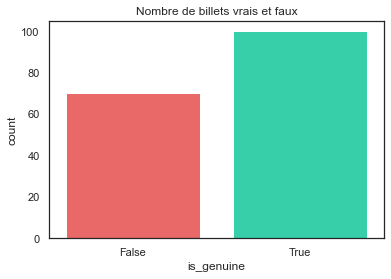

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
save_fig('countplot_isgenuine')
plt.show()

## Analyse des corr√©lations

`sns.pairplot` trace l'histogramme de chaque variable quantitative, pour chaque classe de la variable cat√©gorielle *is_genuine*.

La longueur et la marge basse permettent le mieux de discriminer les vrais billets des faux. 

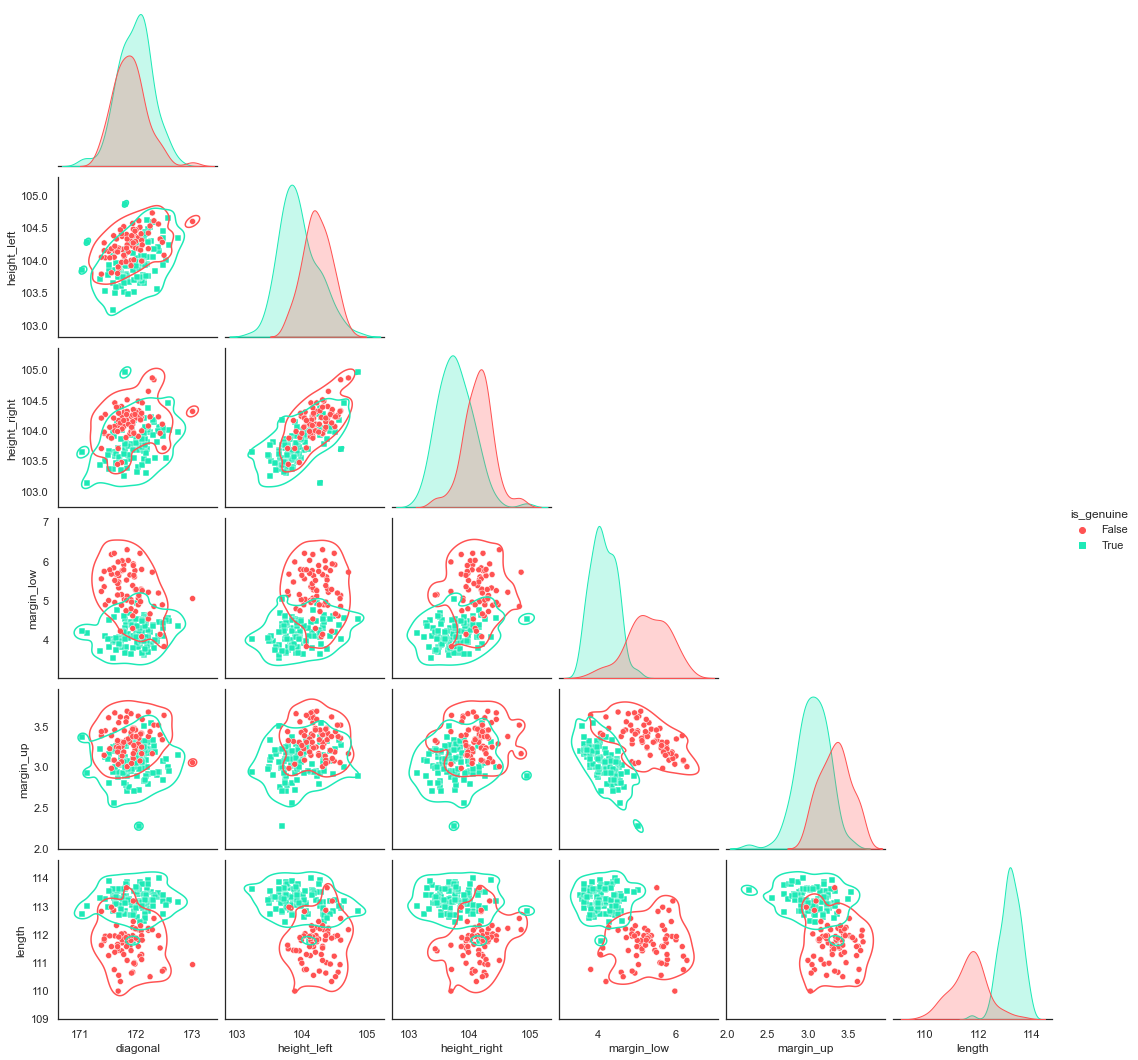

In [9]:
g = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')
save_fig('pairplot')
plt.show()

Les faux billets sont plus courts que les vrais, et leur marge basse est √† l'inverse nettement plus longue.

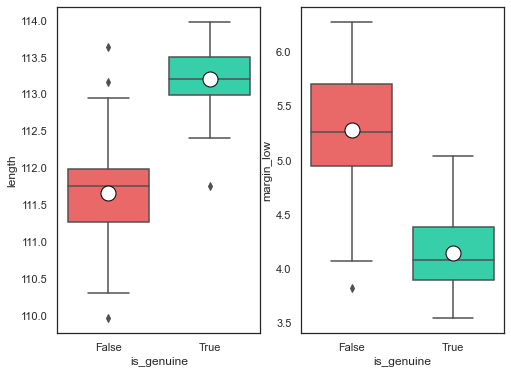

In [10]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
meanprops = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"15"}
sns.boxplot(data=df, y='length', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[0])
sns.boxplot(data=df, y='margin_low', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[1])
save_fig('boxplots')
plt.show()

La matrice des corr√©lations r√©sume les d√©pendances entre variables par une valeur entre -1 et 1 :
- `0` : absence de corr√©lation
- `1` : corr√©lation positive
- `-1` : corr√©lation n√©gative

Elle confirme l'impact de la longueur et de la marge basse sur l'authenticit√© (plus de 0.8 d'√©cart √† 0). On dit donc que la v√©racit√© du billet est corr√©l√©e positivement √† la longueur, et n√©gativement √† la marge basse. Les variables ont toutes des d√©pendances plus ou moins marqu√©es avec les autres, √† part dans une moindre mesure la diagonale. 

In [11]:
matrix = df.corr()
matrix

is_genuine  diagonal  height_left  height_right  margin_low  \
is_genuine      1.000000  0.139223    -0.461730     -0.551309   -0.800111   
diagonal        0.139223  1.000000     0.319584      0.220418   -0.181020   
height_left    -0.461730  0.319584     1.000000      0.734390    0.424530   
height_right   -0.551309  0.220418     0.734390      1.000000    0.509375   
margin_low     -0.800111 -0.181020     0.424530      0.509375    1.000000   
margin_up      -0.582801 -0.027366     0.324788      0.366918    0.171113   
length          0.825743  0.080295    -0.421387     -0.417021   -0.637352   

              margin_up    length  
is_genuine    -0.582801  0.825743  
diagonal      -0.027366  0.080295  
height_left    0.324788 -0.421387  
height_right   0.366918 -0.417021  
margin_low     0.171113 -0.637352  
margin_up      1.000000 -0.525284  
length        -0.525284  1.000000

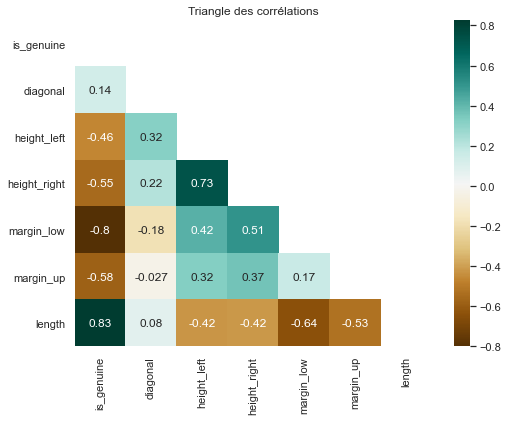

In [12]:
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corr√©lations')
save_fig('triangle-correlations')
plt.show()

# ACP

L'analyse en composantes principales va nous permettre de r√©duire nos 6 variables quantitatives √† 2. On pourra alors repr√©senter chaque billet dans un espace √† 2 dimensions. Ce qui permettra de v√©rifier o√π se situent les vrais et faux billets dans l'espace, et s'ils forment des clusters distincts. L'ACP √©tant sensible √† la variance, on va d'abord standardiser les variables quantitatives.

## Standardisation des variables

M√™me si toutes les variables s'expriment en millim√®tres, leur √©chelle varie. Ici les marges avoisinnent 4mm alors que les longueurs d√©passent 170mm. Pour que les valeurs comme celles de la longueur n'aient pas trop de poids face aux autres, il faut que toutes nos variables s'expriment dans la m√™me unit√©.

Standardiser les variables consiste √† les centrer autour de 0, puis r√©duire √† 1 leur √©cart type (*standard* deviation en anglais, d'o√π le terme *standardisation*). Le centrage ne change pas la forme d'une distribution, il ne fait que la d√©placer.

Pour que la moyenne de chaque variable soit √©gale √† 0, on soustrait √† toutes les observations la moyenne de la variable concern√©e.

In [13]:
import sklearn as sk
from sklearn import preprocessing

In [14]:
X = df.drop(['is_genuine'], axis=1) # Variables quantitatives √† standardiser
std_scale = sk.preprocessing.StandardScaler().fit(X) # Fit des valeurs sur le mod√®le
X_std = pd.DataFrame(std_scale.transform(X), columns=X.columns) # Valeurs standardis√©es
X_std

diagonal  height_left  height_right  margin_low  margin_up    length
0   -0.428344     2.669454      3.096563   -0.131590  -1.189874  0.281633
1   -0.887559    -1.097697     -0.691254   -0.860126  -1.274740  0.780697
2   -0.362742    -1.030427     -0.509439   -0.303010  -1.232307  1.377405
3   -0.461145    -0.963156     -0.842767   -1.260106  -0.213913  1.149571
4    0.358883    -1.232238     -0.539742    0.611230  -3.820725  1.062777
..        ...          ...           ...         ...        ...       ...
165  0.555689     0.550431      1.581436    0.896930   1.738009 -0.857535
166  3.507789     1.761301      1.157201    0.611230  -0.510944 -1.801418
167  1.736529     0.684972      0.520847    0.382670   0.677182 -2.050950
168 -0.395543    -0.324086     -0.145809    0.168395   1.610710 -0.759892
169  0.063673    -0.223180      0.066309    1.454046   0.380151 -1.747172

[170 rows x 6 columns]

Les variables maintenant standardis√©es ont toutes le m√™me √©cart type, proche de 1.

In [15]:
X_std.describe()

diagonal   height_left  height_right    margin_low     margin_up  \
count  1.700000e+02  1.700000e+02  1.700000e+02  1.700000e+02  1.700000e+02   
mean   7.695805e-15  3.147286e-14  3.619588e-14  7.523394e-16 -1.504679e-15   
std    1.002954e+00  1.002954e+00  1.002954e+00  1.002954e+00  1.002954e+00   
min   -2.954029e+00 -2.813096e+00 -2.388197e+00 -1.531521e+00 -3.820725e+00   
25%   -6.907527e-01 -7.529355e-01 -7.215570e-01 -8.029855e-01 -6.700684e-01   
50%    1.447108e-02 -3.818593e-02  6.630909e-02 -2.315852e-01 -1.747245e-03   
75%    6.458924e-01  7.438342e-01  7.329650e-01  7.362241e-01  6.771821e-01   
max    3.507789e+00  2.669454e+00  3.096563e+00  2.382571e+00  2.162340e+00   

             length  
count  1.700000e+02  
mean  -1.375109e-14  
std    1.002954e+00  
min   -2.821245e+00  
25%   -7.761662e-01  
50%    2.979069e-01  
75%    7.779851e-01  
max    1.529294e+00

Les histogrammes confirment que chaque variable a conserv√© sa forme de distribution.

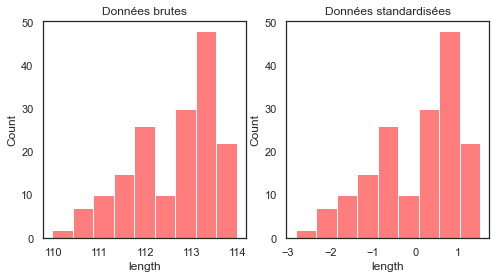

In [16]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(df['length'], ax=ax[0])
sns.histplot(X_std['length'], ax=ax[1])
ax[0].title.set_text('Donn√©es brutes')
ax[1].title.set_text('Donn√©es standardis√©es')
save_fig('histogramme_std')
plt.show()

## Projection sur 2 composantes

L'ACP va nous permettre de visualiser les billets sur un plan √† 2 dimensions, en en r√©duisant les 6 variables standardis√©es √† 2. On compte autant de variables que d'axes d'inertie et de composantes. Chaque composante stocke un certain pourcentage de l'information contenu dans les donn√©es, qu'on nomme variance expliqu√©e. La 1√®re composante sera celle qui stocke le plus d'informations, donc le plus de variance expliqu√©e dans son vecteur.

In [17]:
matrix = X_std.cov()
matrix

diagonal  height_left  height_right  margin_low  margin_up  \
diagonal      1.005917     0.321475      0.221722   -0.182092  -0.027527   
height_left   0.321475     1.005917      0.738736    0.427042   0.326709   
height_right  0.221722     0.738736      1.005917    0.512389   0.369089   
margin_low   -0.182092     0.427042      0.512389    1.005917   0.172125   
margin_up    -0.027527     0.326709      0.369089    0.172125   1.005917   
length        0.080770    -0.423881     -0.419488   -0.641123  -0.528392   

                length  
diagonal      0.080770  
height_left  -0.423881  
height_right -0.419488  
margin_low   -0.641123  
margin_up    -0.528392  
length        1.005917

In [18]:
from sklearn.decomposition import PCA

Les 2 premi√®res composantes expliquent 69% de la variance.

In [19]:
n_components = 2 # Nombre de composantes
pca = PCA(n_components=n_components).fit(X_std)
print(
    'Variance expliqu√©e :', 
    round(sum(pca.explained_variance_ratio_) * 100, 1), '%',
    '\nVariance par composante :', pca.explained_variance_ratio_)

Variance expliqu√©e : 69.4 % 
Variance par composante : [0.47447921 0.21957106]


Chaque composante perd en informations par rapport √† celle qui la pr√©c√®de : l'analyse des √©boulis (*scree plot*) montre leur variance expliqu√©e toujours plus faible.

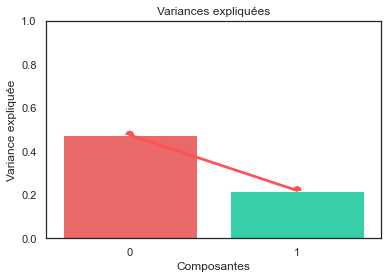

In [20]:
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots(figsize=(6, 4))
sns.barplot(x=ind, y=pca.explained_variance_ratio_)
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Variances expliqu√©es')
ax.set_ylim(0,1)
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Composantes')
ax.set_ylabel('Variance expliqu√©e')
save_fig('acp_eboulis')
plt.show()

On joint les valeurs des composantes √† la dataframe principale, pour pouvoir repr√©senter chaque billet sur le plan factoriel (avec la composante 1 en abscisse et la composante 2 en ordonn√©e). 

In [21]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(X_std)

for i in range(0, n_components): 
    df['PC' + str(i + 1)] = reduced[:, i]
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0          True    171.81       104.86        104.95        4.52       2.89   
1          True    171.67       103.74        103.70        4.01       2.87   
2          True    171.83       103.76        103.76        4.40       2.88   
3          True    171.80       103.78        103.65        3.73       3.12   
4          True    172.05       103.70        103.75        5.04       2.27   
..          ...       ...          ...           ...         ...        ...   
165       False    172.11       104.23        104.45        5.24       3.58   
166       False    173.01       104.59        104.31        5.04       3.05   
167       False    172.47       104.27        104.10        4.88       3.33   
168       False    171.82       103.97        103.88        4.73       3.55   
169       False    171.96       104.00        103.95        5.63       3.26   

     length       PC1       PC2  
0    112.83  2.153639  1.599709  
1    113.29 -2.110416 -0.526039  
2    113.84 -1.973152 -0.048102  
3    113.63 -2.059795 -0.089105  
4    113.55 -2.403180  0.412170  
..      ...       ...       ...  
165  111.78  2.478626  0.189974  
166  110.91  2.585331  2.914472  
167  110.68  2.067245  0.845602  
168  111.87  0.739257 -0.972965  
169  110.96  1.504992 -1.079725  

[170 rows x 9 columns]

Projet√©s sur un plan √† 2 dimensions, les vrais et faux billets forment bien 2 groupes distincts, qu'on pourrait s√©parer par une ligne. 

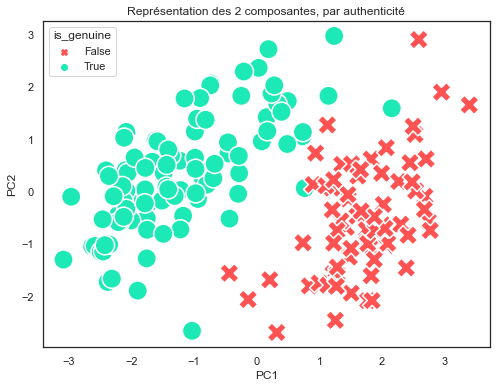

In [22]:
plt.figure(figsize=(8, 6))
scatter_markers = ['X','o']
sns.scatterplot(data=df, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', markers=scatter_markers, s=375)
plt.title('Repr√©sentation des 2 composantes, par authenticit√©')
save_fig('acp_isgenuine')
plt.show()

Le cercle des corr√©lations confirme que les d√©pendances entre variables ont bien √©t√© conserv√©es apr√®s projection. Pour chaque variable, la longueur de la fl√®che est proportionnelle √† la quantit√© d'informations stock√©e par les composantes.

La corr√©lation entre 2 variables se d√©duit par l'angle que forme leurs fl√®ches :

- 0¬∞ : corr√©lation positive
- 90¬∞ : absence de corr√©lation
- 180¬∞ : corr√©lation n√©gative

Les corr√©lations entre les 6 variables de d√©part ont bien √©t√© conserv√©es apr√®s r√©duction en 2 dimensions. Ici, les hauteurs gauche et droite sont bien corr√©l√©es positivement, tout comme les 2 marges. L'ACP a conserv√© suffisamment de donn√©es pour que la repr√©sentation sur le plan factoriel soit fiable.

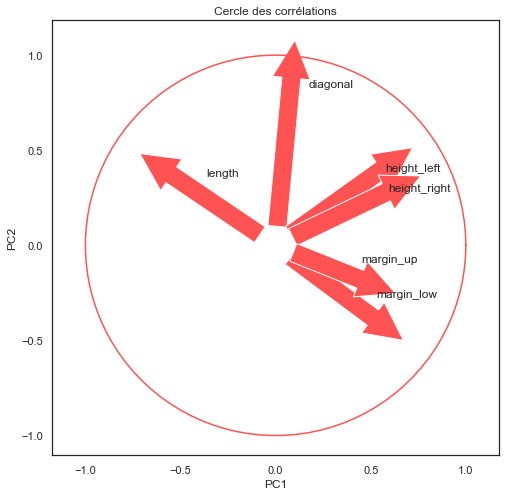

In [23]:
# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.2,
             head_length=0.2, width=.1, head_starts_at_zero=True)
    
    plt.text(pca.components_[0, i] + .1,
             pca.components_[1, i] + .05,
             X_std.columns.values[i])

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Cercle des corr√©lations')
save_fig('cercle-correlations')
plt.show()

# Clustering

L'algorithme **K-means** va permettre de v√©rifier si les donn√©es sont bien lin√©aires, s√©parables en 2 groupes distincts dans l'espace en 2 dimensions. C'est √† cette condition qu'on pourra s'appuyer sur une r√©gression logistique pour classer les billets.

On fixe le nombre de clusters √† 2, √©tant donn√© qu'on cherchera par la r√©gression logistique √† d√©duire les 2 classes de *is_genuine*.

In [24]:
from sklearn import cluster

In [25]:
kmeans = sk.cluster.KMeans(n_clusters=2, random_state=0).fit(X)
df['cluster'] = kmeans.predict(X)
dicto = {0: 1, 1: 0} # Inversion des 0 et des 1
df['cluster'] = df['cluster'].map(dicto) # Pour que 0 soit √©gal √† False
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0          True    171.81       104.86        104.95        4.52       2.89   
1          True    171.67       103.74        103.70        4.01       2.87   
2          True    171.83       103.76        103.76        4.40       2.88   
3          True    171.80       103.78        103.65        3.73       3.12   
4          True    172.05       103.70        103.75        5.04       2.27   
..          ...       ...          ...           ...         ...        ...   
165       False    172.11       104.23        104.45        5.24       3.58   
166       False    173.01       104.59        104.31        5.04       3.05   
167       False    172.47       104.27        104.10        4.88       3.33   
168       False    171.82       103.97        103.88        4.73       3.55   
169       False    171.96       104.00        103.95        5.63       3.26   

     length       PC1       PC2  cluster  
0    112.83  2.153639  1.599709        1  
1    113.29 -2.110416 -0.526039        1  
2    113.84 -1.973152 -0.048102        1  
3    113.63 -2.059795 -0.089105        1  
4    113.55 -2.403180  0.412170        1  
..      ...       ...       ...      ...  
165  111.78  2.478626  0.189974        0  
166  110.91  2.585331  2.914472        0  
167  110.68  2.067245  0.845602        0  
168  111.87  0.739257 -0.972965        0  
169  110.96  1.504992 -1.079725        0  

[170 rows x 10 columns]

Les clusters pr√©dits correspondent √† vue d'oeil aux vraies classes (*is_genuine*), et on peut comme attendu s√©parer les clusters par une ligne droite. Nos donn√©es sont donc adapt√©es pour une r√©gression logistique.

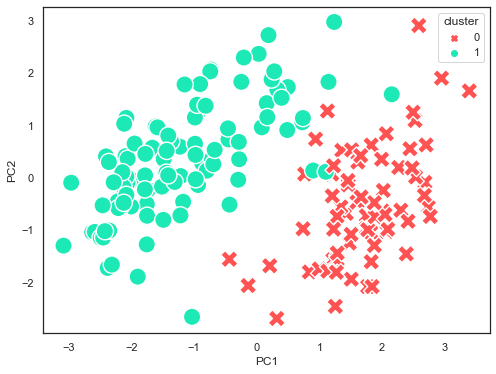

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster', style='cluster', markers=scatter_markers, s=300)
save_fig('kmeans-clusters')
plt.show()

Si on projette sur le m√™me plan la vraie classe (*is_genuine*) et la classe pr√©dite (*cluster*), seuls 3 billets appara√Æssent mal class√©s (les plus gros points indiquent la classe r√©elle, les petits le cluster).

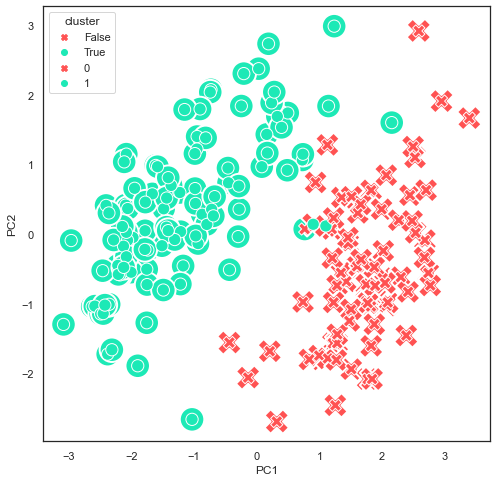

In [27]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='PC1', y='PC2', markers=scatter_markers, style='is_genuine', hue='is_genuine', s=600)
sns.scatterplot(data=df, x='PC1', y='PC2', markers=scatter_markers, style='cluster', hue='cluster', s=150)
save_fig('kmeans_comparaison')
plt.show() # Contour = classe r√©elle ; Point = cluster

On v√©rifie le nombre d'individus vrais d√©tect√©s faux 
avec une **matrice de confusion**.

|                      | Pr√©dit : faux  | Pr√©dit : vrai  |
| -------------------- |:-------------: | -------------: |
| Valeur r√©elle : faux | Vrais n√©gatifs | Faux positifs  |
| Valeur r√©elle : vrai | Faux n√©gatifs  | Vrais positifs |

Deux faux billets ont √©t√© consid√©r√©s comme vrais par le clustering, et seul un vrai billet a √©t√© d√©tect√© comme faux.

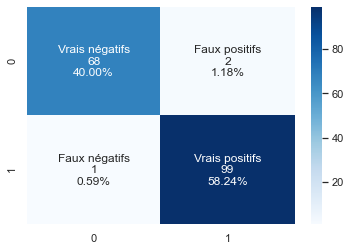

              precision    recall  f1-score   support

       False       0.99      0.97      0.98        70
        True       0.98      0.99      0.99       100

    accuracy                           0.98       170
   macro avg       0.98      0.98      0.98       170
weighted avg       0.98      0.98      0.98       170



In [28]:
def matrice_confusion(a, b, nom_graphique):
    confusion_matrix = sk.metrics.confusion_matrix(a,b)
    group_names = ['Vrais n√©gatifs','Faux positifs','Faux n√©gatifs','Vrais positifs']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = [
        '{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    save_fig(nom_graphique)
    plt.show()
    
    classification = sk.metrics.classification_report(a,b)
    print(classification)
    
matrice_confusion(df['is_genuine'], df['cluster'], 'kmeans_matrice-confusion')

# Mod√©lisation

## Split

On dissocie *is_genuine* (qu'on appelle `y` : la target) des autres variables standardis√©es (`X`). 

In [29]:
y = df['is_genuine'] # Target
y

0       True
1       True
2       True
3       True
4       True
       ...  
165    False
166    False
167    False
168    False
169    False
Name: is_genuine, Length: 170, dtype: bool

Puis `X` et `y` sont divis√©s en 2 √©chantillons `train` et `test`. Les jeux test repr√©senteront ici un tiers des donn√©es.

In [30]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X_std, y, test_size=0.33, random_state=42)

print('X_train :', len(X_train), 'lignes',
    '\ny_train :', len(y_train), 'lignes',
    '\nX_test :', len(X_test), 'lignes',
    '\ny_test :', len(y_test), 'lignes')

X_train : 113 lignes 
y_train : 113 lignes 
X_test : 57 lignes 
y_test : 57 lignes


## Classifieur idiot

On cr√©e un classifieur idiot aux pr√©dictions al√©atoires donc m√©diocres, comme base de comparaison avec notre futur mod√®le. 

En sp√©cifiant `strategy='uniform'`, on obtient des pr√©dictions al√©atoires sans rapport avec nos donn√©es. En sp√©cifiant `prior`, on obtiendrait pour chaque individu la classe la plus fr√©quente dans le jeu de donn√©es.

In [31]:
from sklearn.dummy import DummyClassifier
dummy_biased = DummyClassifier(random_state=0, strategy='uniform')
dummy_biased.fit(X_train, y_train)
y_pred_dummy = dummy_biased.predict(X_test) # Pr√©diction de la target sur les variables de test (X_test)
print(y_pred_dummy)

[False  True  True False  True  True  True  True  True  True  True False
 False  True False False False False False  True False  True  True False
 False  True  True  True  True False  True False  True False  True  True
 False  True  True False False  True False  True  True  True  True  True
 False  True False  True  True  True  True False  True]


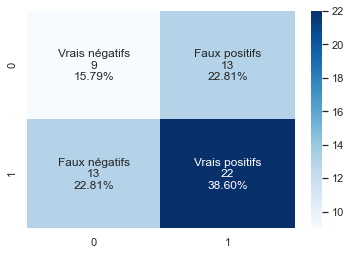

              precision    recall  f1-score   support

       False       0.41      0.41      0.41        22
        True       0.63      0.63      0.63        35

    accuracy                           0.54        57
   macro avg       0.52      0.52      0.52        57
weighted avg       0.54      0.54      0.54        57



In [32]:
matrice_confusion(y_test, y_pred_dummy, 'dummy_matrice-confusion')

## R√©gression logistique

En sortie, on obtient pour chaque billet la probabilit√© qu'il soit vrai, et celle qu'il soit faux.

In [33]:
regression = sk.linear_model.LogisticRegression()
regression.fit(X_train, y_train)

pd.DataFrame(
    regression.predict_proba(X_test)).rename(
    columns={0: 'False', 1: 'True'}).head(10)

False      True
0  0.891750  0.108250
1  0.008633  0.991367
2  0.996318  0.003682
3  0.000202  0.999798
4  0.495264  0.504736
5  0.997718  0.002282
6  0.963555  0.036445
7  0.063299  0.936701
8  0.960113  0.039887
9  0.004716  0.995284

On obtient une constante (intercept), et pour chaque variables un coefficient de corr√©lation, sur lesquels se basera la fonction de r√©gression lin√©aire.
>h(x) = diagonal*0.1388 + ... + length*1.8254 + constante

Pour obtenir l'√©quation de notre r√©gression logistique, on appliquera ensuite cette formule : 
>f(x) = 1/(1+exp(-h(x)))

In [34]:
print('Constante :', regression.intercept_)

Constante : [0.90023436]


In [35]:
print('Coefficients :', regression.coef_)

Coefficients : [[ 0.13882195 -0.19305063 -0.50972116 -1.92453316 -1.43368165  1.82541401]]


La plus forte probabilit√© pour chaque individu d√©termine sa classe pr√©dite, qu'on r√©cup√©re pour ensuite pouvoir la comparer avec **y_test**.

In [36]:
y_log = regression.predict(X_test) # Pr√©dictions sur l'√©chantillon-test
print(y_log)

[False  True False  True  True False False  True False  True  True False
 False  True  True  True  True False  True False  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
  True  True False False  True False  True False False  True  True  True
 False  True False False  True  True  True False  True]


En comparant la target r√©elle du jeu test et nos pr√©dictions, on constate qu'un seul faux billet a √©t√© pr√©dit comme vrai, et un vrai billet a √©t√© consid√©r√© faux.

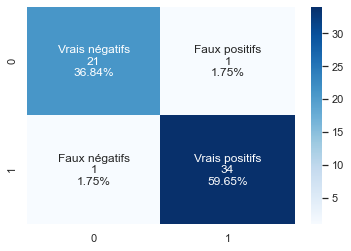

              precision    recall  f1-score   support

       False       0.95      0.95      0.95        22
        True       0.97      0.97      0.97        35

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57



In [37]:
matrice_confusion(y_test, y_log, 'reg_matrice-confusion')

# Shap

SHAP est un outil permettant d'expliquer la sortie d'un mod√®le. Les variables y sont class√©es par leur force de contribution au mod√®le. Comme attendu, la longueur et la marge basse arrivent en t√™te.

En abscisse, l'impact de chaque variable sur le mod√®le. Les valeurs rouges indiquent les plus grandes valeurs de la variable, les bleues ses plus faibles. Le mod√®le est surtout influenc√© par les marges basses les plus faibles (en bleu) et les plus grandes des longueurs.

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


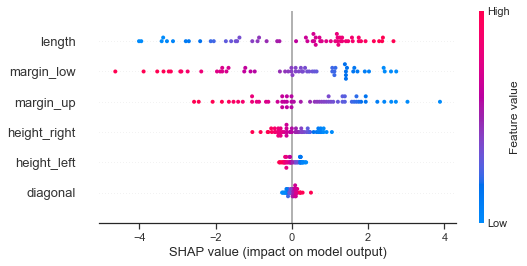

In [38]:
import shap
explainer = shap.LinearExplainer(regression, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns.to_list())

`force_plot` permet pour chaque billet de v√©rifier quelles variables ont impact√© les 2 probabilit√©s de classe. Ici, la marge basse et la longueur pointent en bleu et vers la gauche : elles ont contribu√© √† la classe *False*.  

In [39]:
def force_plot(num_billet):
    print('Billet', num_billet, ':', y_test.iloc[num_billet])
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value, shap_values[num_billet], 
        X_test.iloc[num_billet].values, feature_names=X.columns.to_list())
    
force_plot(5)

Billet 5 : False


Quand les variables pointent en rouge vers la droite, elle contribuent √† la classe positive.

In [40]:
force_plot(24)

Billet 24 : True


# Programme de d√©tection

Pour d√©tecter l'authenticit√© des billets, le programme acceptera un fichier CSV sur ce mod√®le :

In [41]:
pd.read_csv('example.csv')

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

On stocke les donn√©es d'entra√Ænement dans un dictionnaire qu'on enregistera dans un fichier Pickle.

In [42]:
train_dict = {}
train_dict[0] = std_scale
train_dict[1] = regression
train_dict[2] = pca

`pickle.dump()` s√©rialise le dictionnaire, enregistr√© dans le fichier **train.p**. Pour d√©s√©rialiser dans la fonction notre dictionnaire de dataframes, on utilisera `pickle.load()`. 

In [43]:
import pickle

In [44]:
pickle.dump(train_dict, open('train.p', 'wb'))

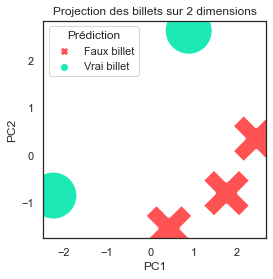

Pr√©diction  Probabilit√© de faux  Probabilit√© de vrai   id
0  Faux billet             0.962899             0.037101  A_1
1  Faux billet             0.994102             0.005898  A_2
2  Faux billet             0.986890             0.013110  A_3
3  Vrai billet             0.058722             0.941278  A_4
4  Vrai billet             0.004059             0.995941  A_5

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
import pickle

def detection(billets_csv): # Programme de d√©tection des faux billets
 
    train_dict = pickle.load(open('train.p', 'rb'))
    std_scale = train_dict[0]
    regression = train_dict[1]
    pca = train_dict[2]
   
    
    billets = pd.read_csv(billets_csv) # en cas de modif du fichier, ajouter sep='\t')
    X_csv = billets.drop(['id'], axis=1)    
    X_csv = pd.DataFrame(std_scale.transform(X_csv), columns=X_csv.columns) # CSV standardis√©
    
    
    y_log = regression.predict(X_csv) # Pr√©dictions
    predictions = []
    for i in range(0, len(y_log)):
        predictions.append(y_log[i])
    
    predictions = pd.concat([ # Jointure des pr√©dictions
        pd.DataFrame(
        [predictions]).rename(index={0: 'Pr√©diction'}).T.replace(
        {False: 'Faux billet', True: 'Vrai billet'}),
        pd.DataFrame(
        regression.predict_proba(X_csv)).rename(
        columns={0: 'Probabilit√© de faux', 1: 'Probabilit√© de vrai'})], axis=1)
    predictions['id'] = billets['id'].unique() 
    
    n_components = 2 # ACP
    reduced = pca.transform(X_csv)
    for i in range(0, n_components):
        predictions['PC' + str(i + 1)] = reduced[:, i]   
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=predictions, x='PC1', y='PC2', markers=['X','o'],
                    hue='Pr√©diction', style='Pr√©diction', s=2500, palette=['#ff5252', '#1de9b6'])
    plt.title('Projection des billets sur 2 dimensions')
    plt.show()
    
    return predictions.iloc[:,:-2]
    
detection('example.csv')

# Ressources

- [A Step-by-Step Explanation of Principal Component Analysis (PCA)](#https://builtin.com/data-science/step-step-explanation-principal-component-analysis)
- [StatQuest : Principal Component Analysis (PCA)](#https://www.youtube.com/watch?v=FgakZw6K1QQ)
- [What Is Normalization and When To Apply?](#https://medium.com/analytics-vidhya/what-is-normalization-and-when-to-apply-bfdf34153bcf)
- [When is precision more important over recall?](#https://www.quora.com/When-is-precision-more-important-over-recall)
- [StatQuest: K-means clustering](#https://www.youtube.com/watch?v=4b5d3muPQmA)
- [La r√©gression logistique en Machine Learning : d√©jouez ses faiblesses](#https://www.youtube.com/watch?v=qToXVhFWGPg)
- [Beginners Take: How Logistic Regression is related to Linear Regression](#https://www.analyticsvidhya.com/blog/2020/12/beginners-take-how-logistic-regression-is-related-to-linear-regression/)